## Imports

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, multilabel_confusion_matrix
from sklearn.manifold import TSNE
from ProteinDataset import ProteinDataset, ProtTransDataset
from utils.config import CFG, Config
from utils.dataset_utils import load_csv
import torch

## Data visualization

t-SNE visualization of ProtVec and ProtTrans embeddings for 5-class

#### ProtVec embeddings

In [112]:
CFG['data']['num_classes'] = 5
CFG.save_config()
CFG = Config()

df_dataset = load_csv(CFG.train_data)
ds = ProteinDataset(df_dataset)
#take a stratified sample of 1000 sequences
df_sample = df_dataset.groupby('label').apply(lambda x: x.sample(min(len(x), 1000))).reset_index(drop=True)
emb = []
for seq in df_sample['sequence']:
    emb.append(ds._create_embedding(seq))

x_encoded = TSNE(n_components=2, init='pca').fit_transform(torch.stack(emb))

/tmp/ipykernel_56766/550176504.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_dataset.groupby('label').apply(lambda x: x.sample(min(len(x), 1000))).reset_index(drop=True)


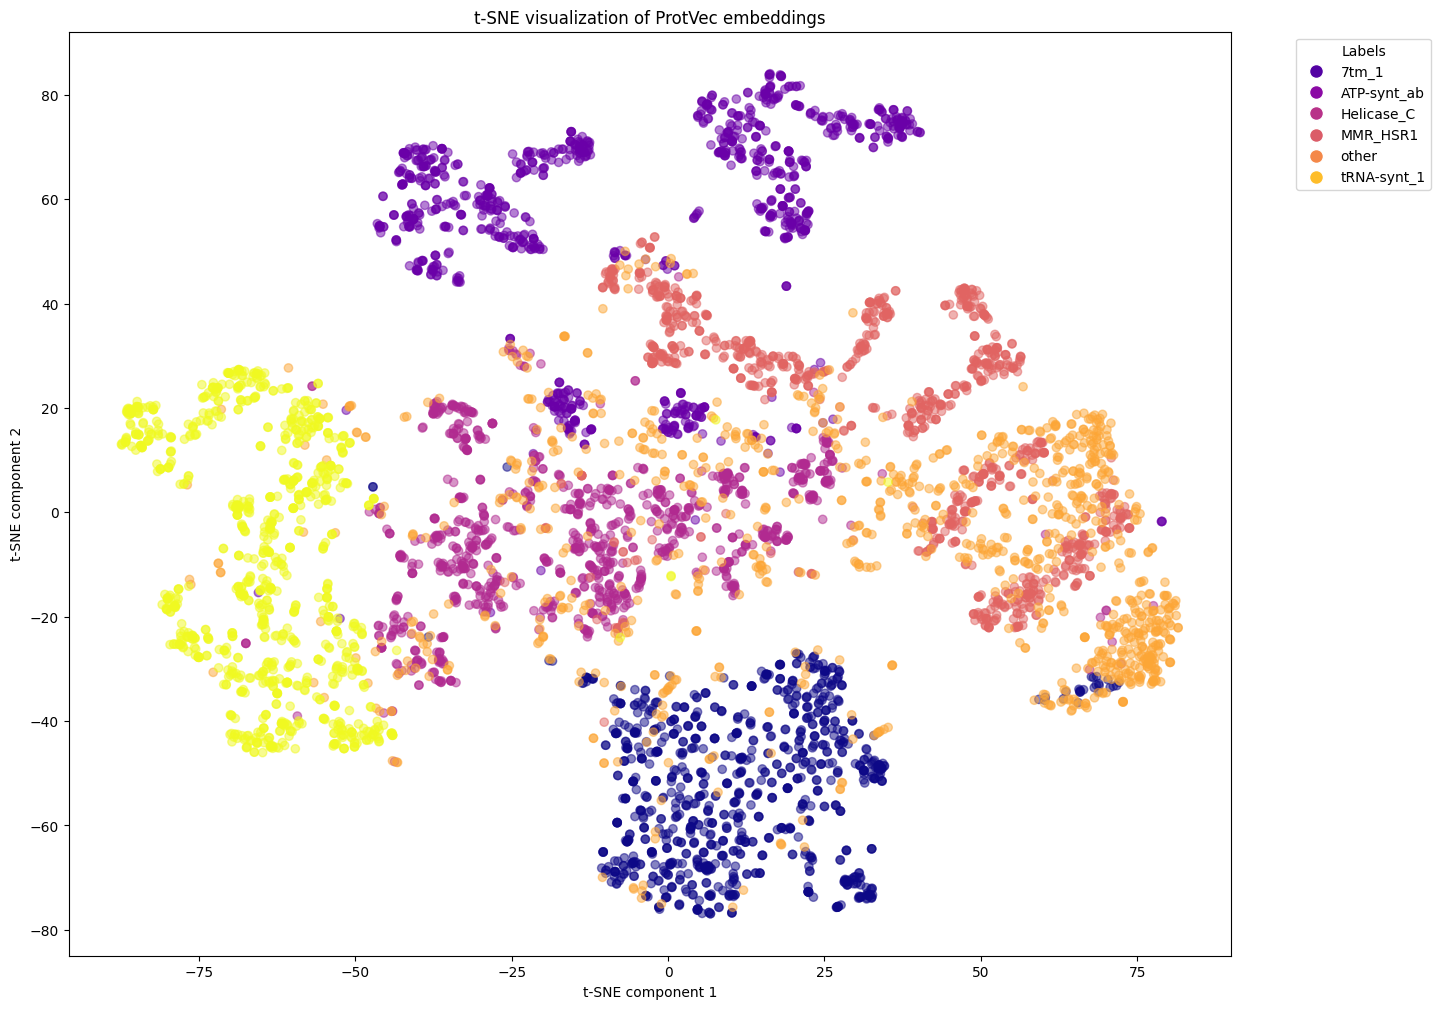

In [113]:
plt.figure(figsize=(15, 12))
plt.scatter(x_encoded[:, 0], x_encoded[:, 1], c=df_sample['label'].astype('category').cat.codes, cmap='plasma', alpha=0.5)
# add legend
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = df_sample['label'].astype('category').cat.categories
for i, label in enumerate(unique_labels):
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=label, 
                               markerfacecolor=sns.color_palette("plasma", n_colors=len(unique_labels))[i], markersize=10))
plt.legend(handles=handles, title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('t-SNE visualization of ProtVec embeddings')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()

#### ProtTrans embeddings 

In [114]:
df_dataset = load_csv(CFG.train_data)
ds = ProtTransDataset(df_dataset, CFG.train_data)
#take a stratified sample of 1000 sequences
df_sample = df_dataset.groupby('label').apply(lambda x: x.sample(min(len(x), 1000)))
emb_df = ds.to_pandas()
emb = emb_df[emb_df['sequence'].isin(df_sample['sequence'])].iloc[:, 1:].to_numpy()

x_encoded = TSNE(n_components=2, init='pca').fit_transform(emb)

/tmp/ipykernel_56766/865699552.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_dataset.groupby('label').apply(lambda x: x.sample(min(len(x), 1000)))


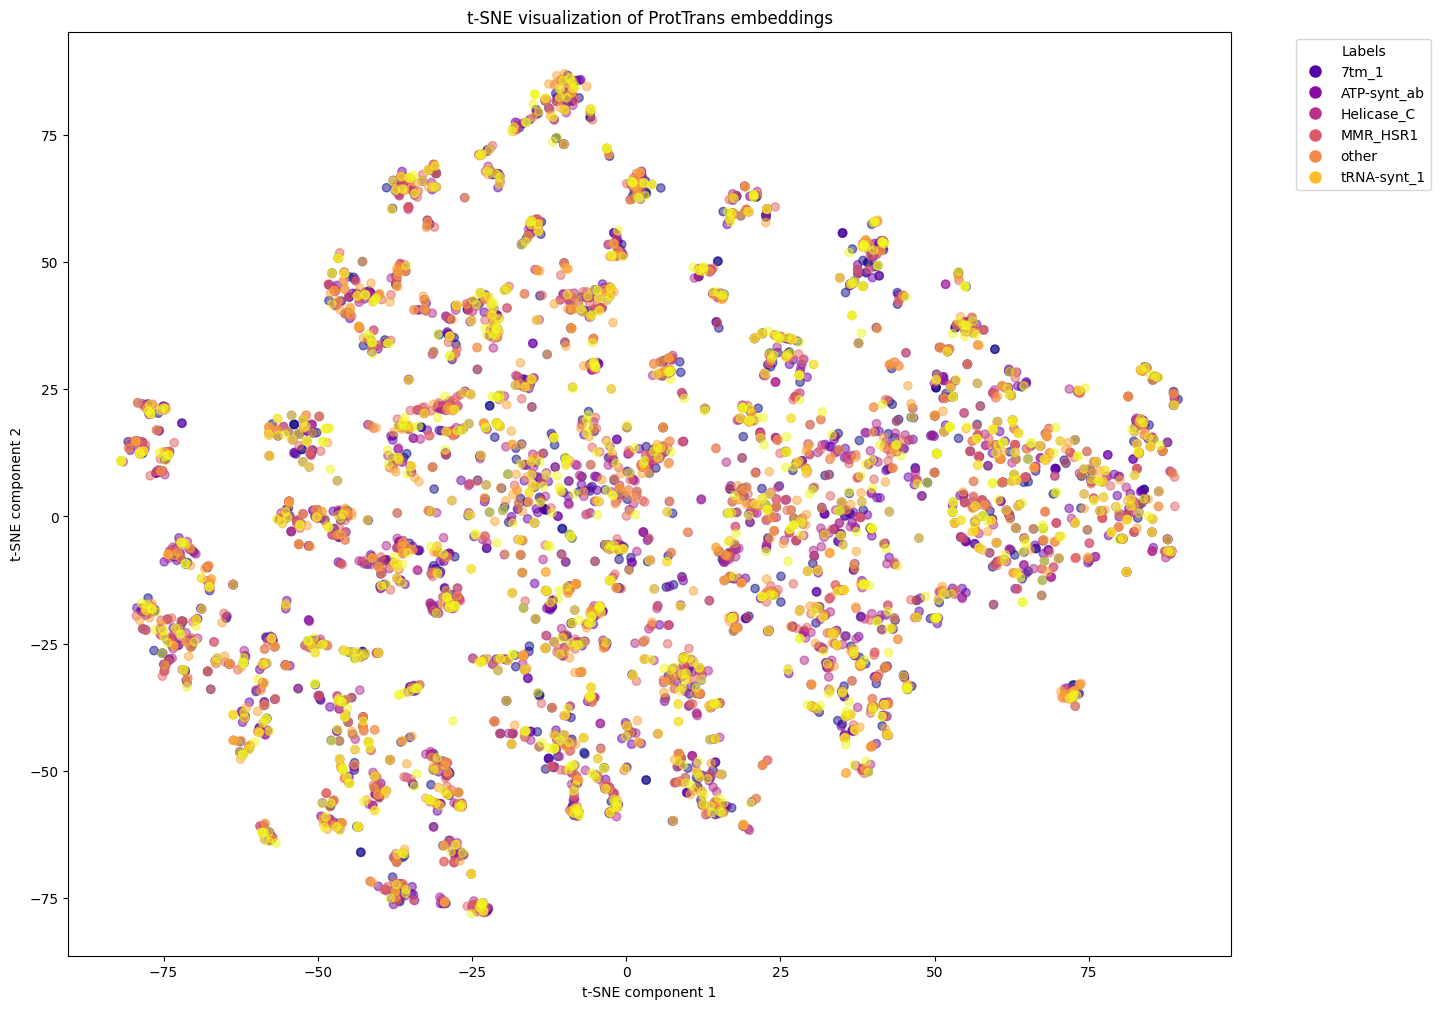

In [115]:
plt.figure(figsize=(15, 12))
plt.scatter(x_encoded[:, 0], x_encoded[:, 1], c=df_sample['label'].astype('category').cat.codes, cmap='plasma', alpha=0.5)
# add legend
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = df_sample['label'].astype('category').cat.categories
for i, label in enumerate(unique_labels):
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=label, 
                               markerfacecolor=sns.color_palette("plasma", n_colors=len(unique_labels))[i], markersize=10))
plt.legend(handles=handles, title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('t-SNE visualization of ProtTrans embeddings')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()

# MLP on ProtVec embeddings

In [3]:
CFG['data']['num_classes'] = 5
CFG.save_config()
CFG = Config()

In [4]:
csv_path = CFG.root_dir / "outputs/predictions"

df_test = load_csv(CFG.test_data)
df_test.to_csv("test_sequences_5classes.csv", index=False)

df_protVec = pd.read_csv(csv_path / "ProtVecClassifier_5classes_predictions.csv")

In [6]:
y_true = df_test["label"].values
y_pred = df_protVec["prediction"].values
print(classification_report(y_true, y_pred))
print("Accuracy: ", balanced_accuracy_score(y_true, y_pred, adjusted=True))

              precision    recall  f1-score   support

       7tm_1       0.34      0.97      0.50       246
 ATP-synt_ab       0.95      0.98      0.96       277
  Helicase_C       0.29      0.93      0.44       193
    MMR_HSR1       0.62      0.91      0.74       277
       other       1.00      0.97      0.98     34308
 tRNA-synt_1       0.71      0.98      0.82       177

    accuracy                           0.97     35478
   macro avg       0.65      0.96      0.74     35478
weighted avg       0.99      0.97      0.97     35478

Accuracy:  0.9480117377268622


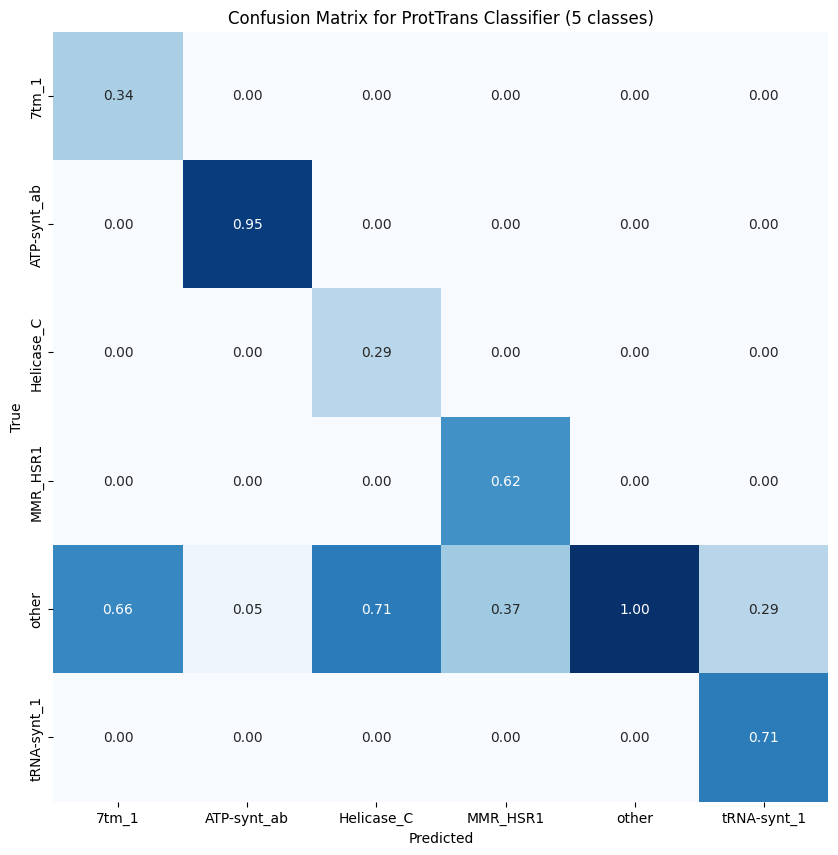

In [158]:
cm = confusion_matrix(y_true, y_pred, normalize='pred')
labels = sorted(df_protVec["prediction"].unique())
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for ProtTrans Classifier (5 classes)')
plt.show()

# LSTM on ProtVec embeddings

In [7]:
CFG['data']['num_classes'] = 5
CFG.save_config()
CFG = Config()

In [13]:
csv_path = CFG.root_dir / "outputs/predictions"

df_test = load_csv(CFG.test_data)
df_test.to_csv("test_sequences_5classes.csv", index=False)

df_LSTM = pd.read_csv(csv_path / "LSTMClassifier_5classes_predictions.csv")

In [14]:
y_true = df_LSTM["label"].values
y_pred = df_LSTM["predicted_label"].values
print(classification_report(y_true, y_pred))
print("Accuracy: ", balanced_accuracy_score(y_true, y_pred, adjusted=True))

              precision    recall  f1-score   support

           0       0.48      0.95      0.64       245
           1       0.87      0.99      0.93       277
           2       0.36      0.97      0.53       193
           3       0.80      0.98      0.88       277
           4       1.00      0.98      0.99     34287
           5       0.84      0.99      0.91       177

    accuracy                           0.98     35456
   macro avg       0.73      0.98      0.81     35456
weighted avg       0.99      0.98      0.98     35456

Accuracy:  0.9717388960264047


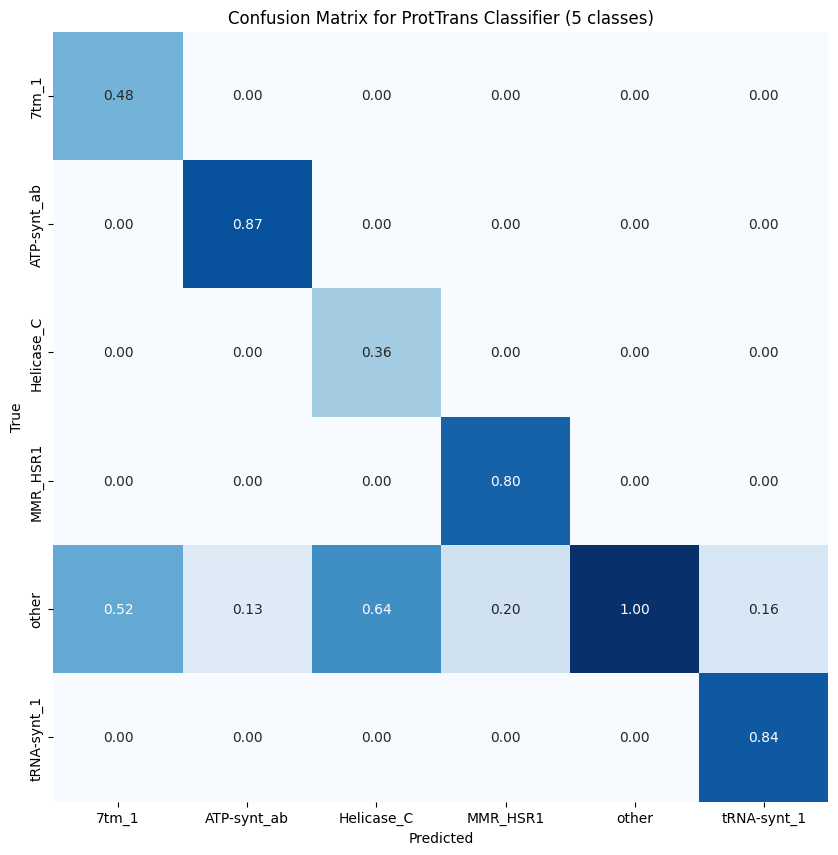

In [18]:
cm = confusion_matrix(y_true, y_pred, normalize='pred')
labels = sorted(df_test["label"].unique())
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for ProtTrans Classifier (5 classes)')
plt.show()

# MLP on ProtTrans embeddings

In [136]:
CFG['data']['num_classes'] = 5
CFG.save_config()
CFG = Config()

In [137]:
csv_path = CFG.root_dir / "outputs/predictions"

df_test = load_csv(CFG.test_data)
df_test.to_csv("test_sequences_5classes.csv", index=False)

df_protTrans = pd.read_csv(csv_path / "ProtTransClassifier_5classes_predictions.csv")

In [138]:
y_true = df_test["label"].values
y_pred = df_protTrans["prediction"].values
print(classification_report(y_true, y_pred))
print("Accuracy: ", balanced_accuracy_score(y_true, y_pred, adjusted=True))

              precision    recall  f1-score   support

       7tm_1       0.89      1.00      0.94       246
 ATP-synt_ab       0.99      1.00      0.99       277
  Helicase_C       0.78      1.00      0.88       193
    MMR_HSR1       0.94      1.00      0.97       277
       other       1.00      1.00      1.00     34308
 tRNA-synt_1       0.85      1.00      0.92       177

    accuracy                           1.00     35478
   macro avg       0.91      1.00      0.95     35478
weighted avg       1.00      1.00      1.00     35478

Accuracy:  0.997763138677068


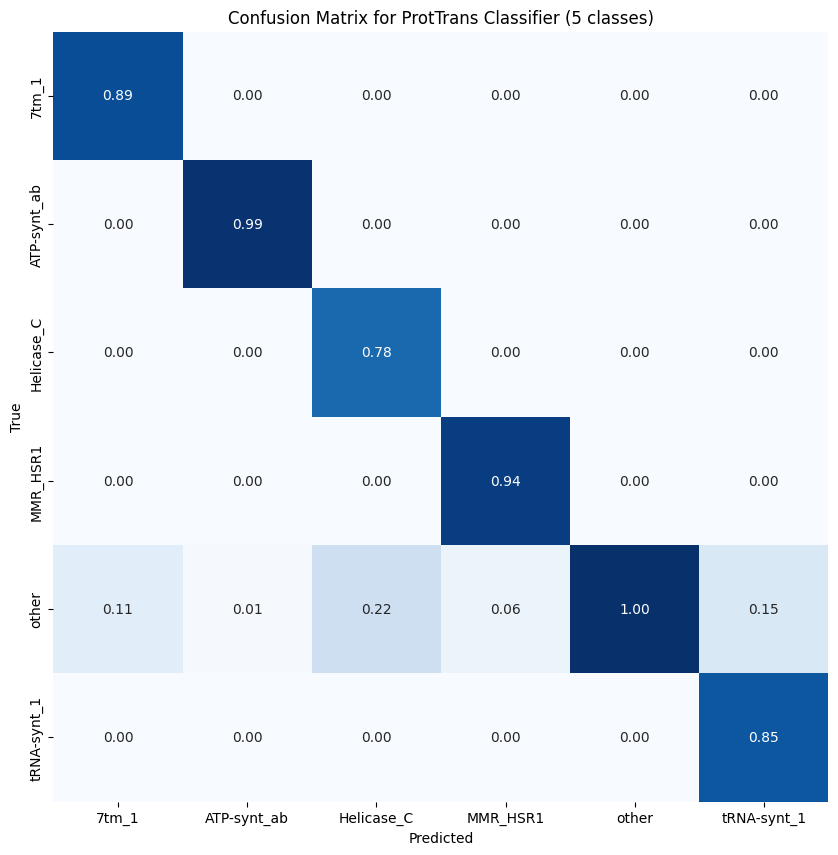

In [139]:
cm = confusion_matrix(y_true, y_pred, normalize='pred')
labels = sorted(df_protTrans["prediction"].unique())
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for ProtTrans Classifier (5 classes)')
plt.show()

## Prediction for 100 classes using ProtTrans embeddings

In [140]:
CFG['data']['num_classes'] = 100
CFG.save_config()
CFG = Config()

In [141]:
csv_path = CFG.root_dir / "outputs/predictions"

df_test = load_csv(CFG.test_data)
df_test.to_csv("test_sequences_100classes.csv", index=False)

df_protTrans = pd.read_csv(csv_path / "ProtTransClassifier_100classes_predictions.csv")

In [142]:
y_true = df_test["label"].values
y_pred = df_protTrans["prediction"].values

In [143]:
print(balanced_accuracy_score(y_true, y_pred, adjusted=True))

0.9916984803401796


In [144]:
print(classification_report(y_true, y_pred))

                 precision    recall  f1-score   support

          7tm_1       0.92      0.99      0.95       246
            AAA       0.63      0.98      0.77       127
      AA_kinase       0.93      0.99      0.96       154
    AMP-binding       0.78      1.00      0.87        76
     ATP-synt_B       0.93      1.00      0.96        95
    ATP-synt_ab       0.98      1.00      0.99       277
     ATP_bind_3       0.89      0.99      0.94        85
      Aconitase       0.95      1.00      0.98        80
         Aldedh       0.81      1.00      0.90       150
        Amidase       0.97      1.00      0.98        85
          Ank_2       0.68      0.93      0.79       108
           BRCT       0.86      0.99      0.92       107
           BacA       1.00      0.97      0.99        78
    CTP_synth_N       1.00      1.00      1.00        80
Chorismate_synt       0.99      0.99      0.99        86
     Cpn60_TCP1       0.97      0.98      0.97       153
          DHHA1       0.88    

#### Confusion matrix of the last 25 classes

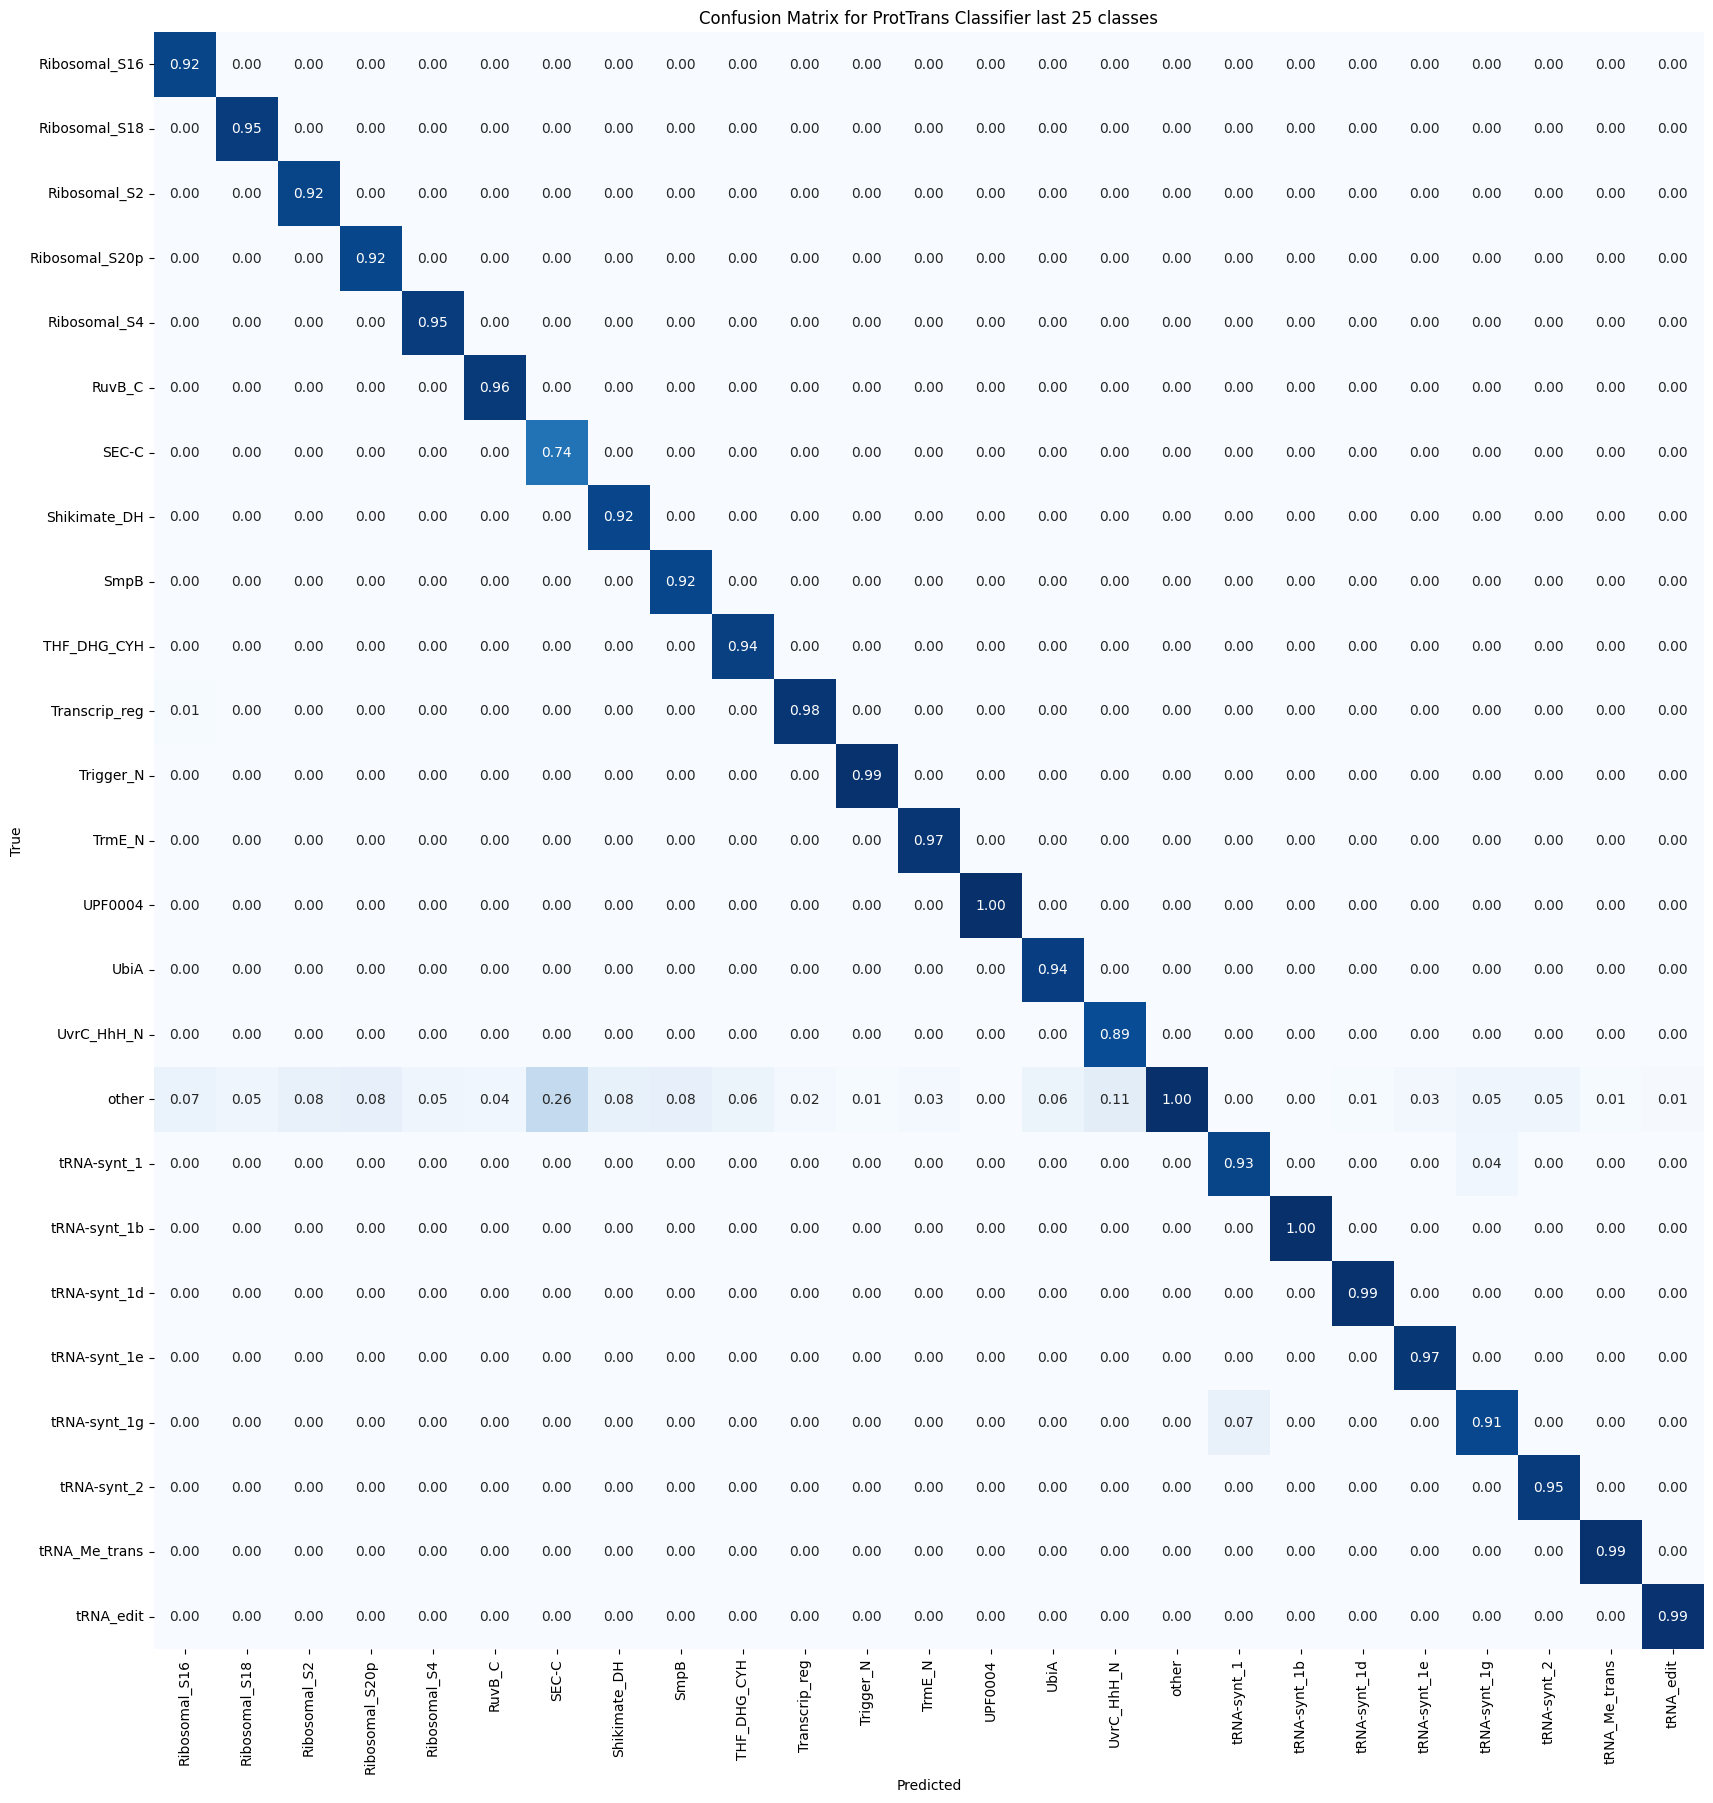

In [145]:
labels = sorted(df_protTrans["prediction"].unique())[75:100]
cm = confusion_matrix(y_true, y_pred, normalize='pred', labels=labels)
plt.figure(figsize=(20, 21))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for ProtTrans Classifier last 25 classes')
plt.show()